In [38]:
import pandas
import re
import matplotlib.pyplot as plt
import seaborn

In [2]:
data = pandas.read_csv("data/train.csv")

In [4]:
data.isnull().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [35]:
#data["Name"].str.extract(' ([A-Za-z]+)\.')[0].value_counts()
title_data = pandas.DataFrame({"name": data["Name"].str.extract(' ([A-Za-z]+)\.')[0],
                               "count": 1,
                               "survived": data["Survived"]})
title_data.groupby("name").sum()

,count,survived
name,,
Capt,1,0
Col,2,1
Countess,1,1
Don,1,0
Dr,7,3
Jonkheer,1,0
Lady,1,1
Major,2,1
Master,40,23


In [13]:
data["Survived"].unique()

array([0, 1])

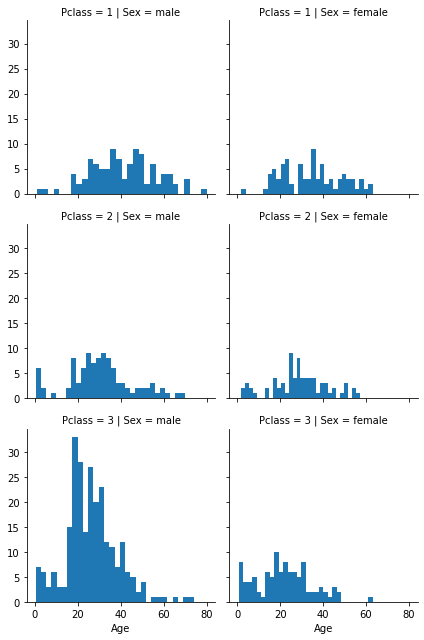

In [49]:
g = seaborn.FacetGrid(data, col='Sex', row='Pclass')
g.map(plt.hist, 'Age', bins=30)


In [36]:
pandas.qcut(data["Fare"], 4)

0       (-0.001, 7.91]
1      (31.0, 512.329]
2       (7.91, 14.454]
3      (31.0, 512.329]
4       (7.91, 14.454]
            ...       
886     (7.91, 14.454]
887     (14.454, 31.0]
888     (14.454, 31.0]
889     (14.454, 31.0]
890     (-0.001, 7.91]
Name: Fare, Length: 891, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 7.91] < (7.91, 14.454] < (14.454, 31.0] < (31.0, 512.329]]

In [12]:
data["Parch"].corr(data["Survived"])

0.08162940708348372

In [46]:
data["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [151]:
%matplotlib inline
data["Title"] = data["Name"].str.extract(' ([A-Za-z]+)\.')
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col', \
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'Mlle', 'Mme'], 'Other')
pandas.crosstab(data["Title"], data["Survived"])

Survived,0,1
Title,,
Master,17,23
Miss,55,127
Mr,436,81
Mrs,26,99
Ms,0,1
Other,15,11


In [13]:
baseline_accuracy = (((data['Sex'] == 'female').astype(int)) == data['Survived']).mean()
baseline_accuracy

0.7867564534231201

In [176]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import re

def transform_row(row):
    # in train dataset, everyone has a
    # - Pclass
    # - Sex
    # - SibSp
    # - Parch
    # - Ticket
    # - Fare

    # some are missing
    # - Age: 177
    # - Cabin: 687
    # - Embarked: 2
    row["PassengerId"] = int(row["PassengerId"])
    if "Survived" in row:
        row["Survived"] = int(row["Survived"])

    # 1, 2, or 3
    row["Pclass"] = int(row["Pclass"])

    # Sex can be "male" or "female"
    row["Sex-male"] = row["Sex"] == "male"
    row["Sex-female"] = row["Sex"] == "female"

    if row["Age"]:
        row["Age"] = float(row["Age"])
    else:
        row["Age"] = 35.0

    if isinstance(row["Cabin"], str):
        # some in the data have multiple cabins, just take the first one
        # Titanic has cabins from A to G deck
        match = re.match(r"([A-G])(\d+)", row["Cabin"])
        if match:
            deck, number = match.groups()
            row["Cabin"] = {"deck": deck,
                            "number": int(number)}
        else:
            row.pop('Cabin')
    else:
        row.pop('Cabin')

    row["SibSp"] = int(row["SibSp"])
    row["Parch"] = int(row["Parch"])
    #row["Ticket"] = int(row["Ticket"])
    if row["Fare"]:
        row["Fare"] = float(row["Fare"])
    else:
        row["Fare"] = 0.0
    
    title = re.search(' ([A-Za-z]+)\.', row["Name"], re.IGNORECASE).group(1)
    if title in ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'Mlle', 'Mme']:
        title = 'Other'
    row["Title"] = {"Master": 0, "Miss": 1, "Mr": 2, "Mrs": 3, "Ms": 4, "Other": 5}.get(title)

    return row


def row_to_model_input(row):
    new_age_bucket = -1
    if not np.isnan(row["Age"]):
        if row["Age"] <= 20.125:
            new_age_bucket = 0
        elif (20.125 < row["Age"]) and (row["Age"] <= 28.0):
            new_age_bucket = 1
        elif (28 < row["Age"]) and (row["Age"] <= 38):
            new_age_bucket = 2
        elif 38 < row["Age"]:
            new_age_bucket = 3
            
    fare_bucket = -1
    if not np.isnan(row["Fare"]):
        if row["Fare"] <= 7.91:
            fare_bucket = 0
        elif (7.91 < row["Fare"]) and (row["Fare"] <= 14.454):
            fare_bucket = 1
        elif (14.454 < row["Fare"]) and (row["Fare"] <= 31):
            fare_bucket = 2
        elif (31 < row["Fare"]):
            fare_bucket = 3
            
    cabin_deck_bucket = -1
    cabin_number_bucket = -1
    if row.get("Cabin", {}).get("deck"):
        cabin_deck_bucket = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6}.get(row.get("Cabin", {}).get("deck"))
    if row.get("Cabin", {}).get("number"):
        cabin_number = row.get("Cabin", {}).get("number")
        if cabin_number < 25:
            cabin_number_bucket = 0
        elif cabin_number < 50:
            cabin_number_bucket = 1
        elif cabin_number < 75:
            cabin_number_bucket = 2
        elif cabin_number < 100:
            cabin_number_bucket = 3
        else:
            cabin_number_bucket = 4
    
    embarked_bucket = -1
    if isinstance(row["Embarked"], str):
        embarked_bucket = {"C": 0, "Q": 1, "S": 2}.get(row["Embarked"])
    
    num_siblings = row["SibSp"] if not np.isnan(row["SibSp"]) else 0
    num_parents = row["Parch"] if not np.isnan(row["Parch"]) else 0
    total_family_size = num_siblings + num_parents + 1
    
    output = np.array([
        row["Pclass"],
        row["Title"],
        new_age_bucket,
        0 if row["Sex-male"] else 1,
        cabin_deck_bucket,
        cabin_number_bucket,
        # don't use cabin number.. for now
        total_family_size,
        fare_bucket,
        embarked_bucket
    ], dtype=np.float32)
    return output

train_data = [row_to_model_input(transform_row(row)) for idx, row in data.iterrows()]
train_labels = [row["Survived"] for idx, row in data.iterrows()]

In [155]:
train_data

[array([ 3.,  2.,  1.,  0., -1., -1.,  2.,  0.,  2.], dtype=float32),
 array([1., 3., 2., 1., 2., 3., 2., 3., 0.], dtype=float32),
 array([ 3.,  1.,  1.,  1., -1., -1.,  1.,  1.,  2.], dtype=float32),
 array([1., 3., 2., 1., 2., 4., 2., 3., 2.], dtype=float32),
 array([ 3.,  2.,  2.,  0., -1., -1.,  1.,  1.,  2.], dtype=float32),
 array([ 3.,  2., -1.,  0., -1., -1.,  1.,  1.,  1.], dtype=float32),
 array([1., 2., 3., 0., 4., 1., 1., 3., 2.], dtype=float32),
 array([ 3.,  0.,  0.,  0., -1., -1.,  5.,  2.,  2.], dtype=float32),
 array([ 3.,  3.,  1.,  1., -1., -1.,  3.,  1.,  2.], dtype=float32),
 array([ 2.,  3.,  0.,  1., -1., -1.,  2.,  2.,  0.], dtype=float32),
 array([3., 1., 0., 1., 6., 0., 3., 2., 2.], dtype=float32),
 array([1., 1., 3., 1., 2., 4., 1., 2., 2.], dtype=float32),
 array([ 3.,  2.,  0.,  0., -1., -1.,  1.,  1.,  2.], dtype=float32),
 array([ 3.,  2.,  3.,  0., -1., -1.,  7.,  3.,  2.], dtype=float32),
 array([ 3.,  1.,  0.,  1., -1., -1.,  1.,  0.,  2.], dtype=float

In [177]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)# Train the model on training data
one_hot_labels = np.identity(2)[train_labels]
rf.fit(train_data, one_hot_labels);

In [178]:
train_predictions = rf.predict(train_data)
survived = train_predictions[:, 1]
train_accuracy = np.mean(np.array(survived, np.int32) == train_labels)
train_accuracy

0.9281705948372615

In [179]:
raw_test_data = pandas.read_csv("data/test.csv")
test_data = [row_to_model_input(transform_row(row)) for idx, row in raw_test_data.iterrows()]
test_predictions = rf.predict(test_data)
test_survived = test_predictions[:, 1]
test_output = [{"PassengerId": raw_data["PassengerId"], "Survived": int(test_survived[idx])} 
               for idx, raw_data in raw_test_data.iterrows()]
test_df = pandas.DataFrame(test_output)

In [180]:
test_df.to_csv("predictions.csv", index=False)